In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parents[1]
sys.path.append(str(PROJECT_ROOT))


In [4]:
import sys
from pathlib import Path

cwd = Path().resolve()

# suche nach einem Parent-Ordner, der "src" enthält
PROJECT_ROOT = next(p for p in [cwd] + list(cwd.parents) if (p / "src").exists())

sys.path.insert(0, str(PROJECT_ROOT))

print("Notebook cwd:", cwd)
print("PROJECT_ROOT:", PROJECT_ROOT)
print("src exists:", (PROJECT_ROOT / "src").exists())


Notebook cwd: C:\Users\Simon\Documents\Studium\5_Semester\DataTypes\ehr-project\AkiNotebooks
PROJECT_ROOT: C:\Users\Simon\Documents\Studium\5_Semester\DataTypes\ehr-project
src exists: True


In [5]:
from src.db import q
from src.cohort import AKI_ICU_SQL
from src.utils import add_ethnicity_group

aki_demo = q(AKI_ICU_SQL)

aki_demo = aki_demo[aki_demo["age"].between(18, 90)]

aki_demo = add_ethnicity_group(aki_demo)
aki_demo.head()





,subject_id,hadm_id,icustay_id,intime,outtime,gender,dob,admittime,dischtime,deathtime,ethnicity,age,hospital_mortality,ethnicity_group
0,268,110404,280836,2198-02-14 23:27:38,2198-02-18 05:26:11,F,2132-02-21,2198-02-11 13:40:00,2198-02-18 03:55:00,2198-02-18 03:55:00,HISPANIC OR LATINO,65.0,1,HISPANIC
1,275,129886,219649,2170-10-07 11:28:53,2170-10-14 14:38:07,M,2088-08-07,2170-10-06 03:09:00,2170-10-19 15:35:00,2170-10-19 15:35:00,WHITE,82.0,1,WHITE
2,279,192224,204407,2164-06-14 21:18:27,2164-06-18 22:53:12,M,2090-02-27,2164-06-13 19:19:00,2164-06-19 17:15:00,NaT,WHITE,74.0,0,WHITE
3,281,111199,257572,2101-10-18 04:45:22,2101-10-25 22:29:25,F,2041-10-12,2101-10-18 04:42:00,2101-10-25 19:10:00,2101-10-25 19:10:00,BLACK/AFRICAN AMERICAN,60.0,1,BLACK
4,294,152578,222074,2118-01-17 21:45:05,2118-01-20 11:12:45,M,2039-05-21,2118-01-17 21:44:00,2118-02-02 16:07:00,NaT,UNKNOWN/NOT SPECIFIED,78.0,0,OTHER


In [6]:
import numpy as np
import pandas as pd

# Zeitspalten robust zu datetime konvertieren
for c in ["intime", "outtime", "admittime", "dischtime", "deathtime"]:
    if c in aki_demo.columns:
        aki_demo[c] = pd.to_datetime(aki_demo[c], errors="coerce")

# LOS berechnen
aki_demo["icu_los_days"] = (aki_demo["outtime"] - aki_demo["intime"]).dt.total_seconds() / 86400
aki_demo["hosp_los_days"] = (aki_demo["dischtime"] - aki_demo["admittime"]).dt.total_seconds() / 86400

# (optional) negative/0 oder unsinnige Werte rausfiltern (kann bei Datenproblemen passieren)
aki_demo.loc[aki_demo["icu_los_days"] < 0, "icu_los_days"] = np.nan
aki_demo.loc[aki_demo["hosp_los_days"] < 0, "hosp_los_days"] = np.nan

# Kurz-Summary (Median/IQR ist bei LOS sinnvoll)
def median_iqr(s):
    s = s.dropna()
    return pd.Series({
        "n": s.shape[0],
        "median": s.median(),
        "p25": s.quantile(0.25),
        "p75": s.quantile(0.75),
        "mean": s.mean()
    })

los_summary = pd.DataFrame({
    "icu_los_days": median_iqr(aki_demo["icu_los_days"]),
    "hosp_los_days": median_iqr(aki_demo["hosp_los_days"]),
}).T

los_summary


,n,median,p25,p75,mean
icu_los_days,11926.0,3.053484,1.686479,6.896808,6.160766
hosp_los_days,11912.0,10.931250,5.892361,20.979861,16.541101


ICU LOS (days) by hospital_mortality (0=alive, 1=dead):
                       n    median       p25       p75      mean
hospital_mortality                                              
0                   9170  2.918206  1.660778  6.091429  5.755483
1                   2756  4.143368  1.824190  9.487627  7.509259 

Hospital LOS (days) by hospital_mortality (0=alive, 1=dead):
                       n     median       p25        p75       mean
hospital_mortality                                                 
0                   9170  10.975694  6.098611  20.881424  16.328691
1                   2742  10.783333  4.604340  21.710417  17.251457 

ICU LOS (days) by gender:
           n    median       p25       p75      mean
gender                                              
F       4907  3.009225  1.685278  6.793490  5.903890
M       7019  3.081505  1.687054  6.954387  6.340349 

Hospital LOS (days) by gender:
           n     median       p25        p75       mean
gender              

C:\Users\Simon\AppData\Local\Temp\ipykernel_32692\3762541335.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return x.groupby(group_col)[los_col].agg(
C:\Users\Simon\AppData\Local\Temp\ipykernel_32692\3762541335.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return x.groupby(group_col)[los_col].agg(
C:\Users\Simon\AppData\Local\Temp\ipykernel_32692\3762541335.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


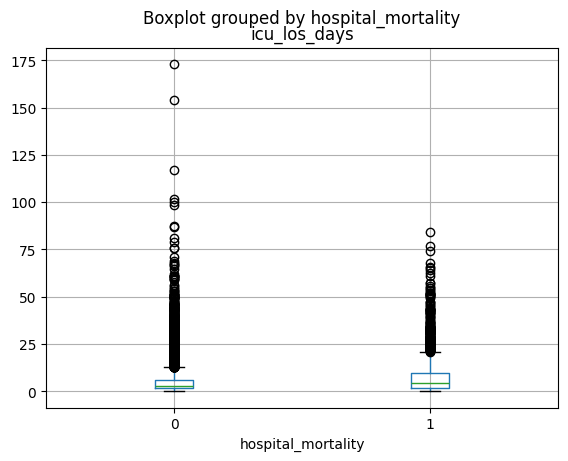

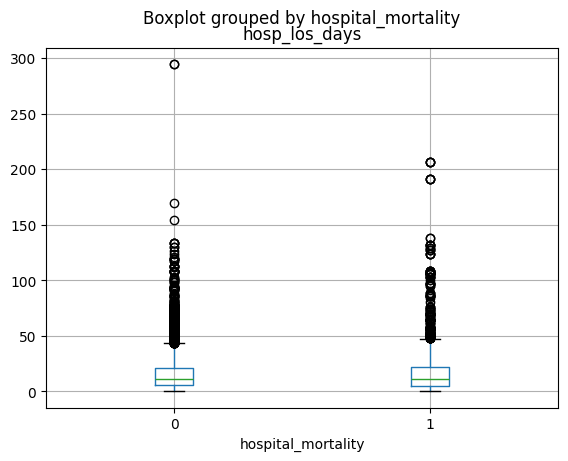

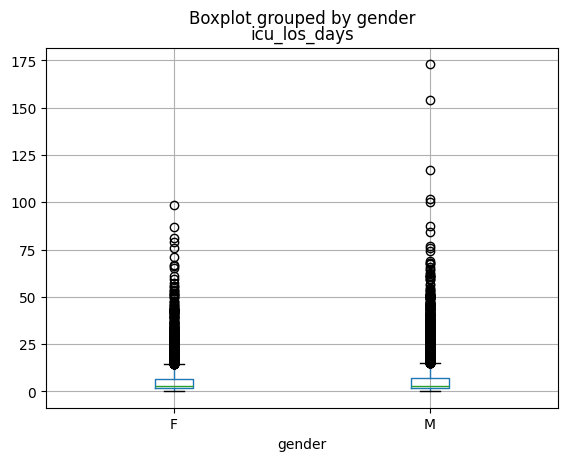

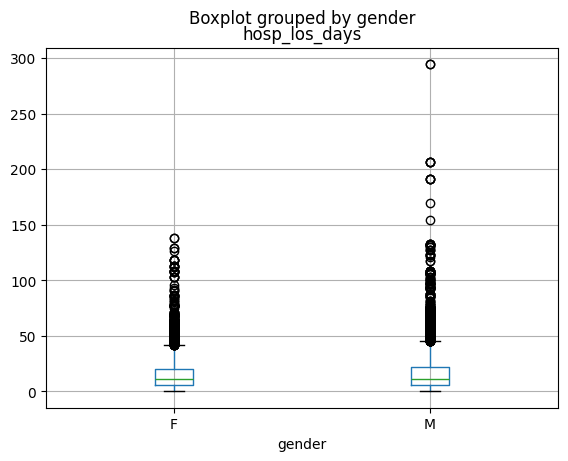

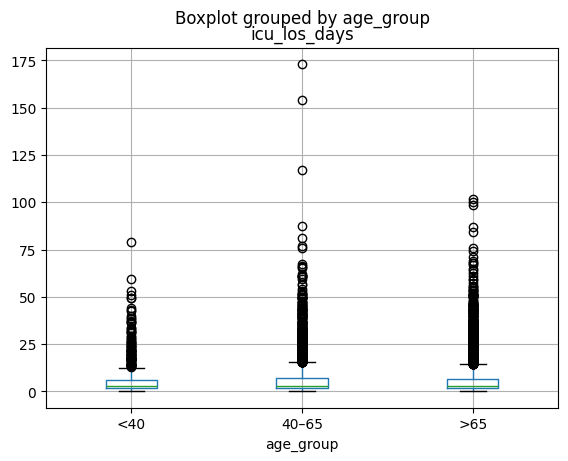

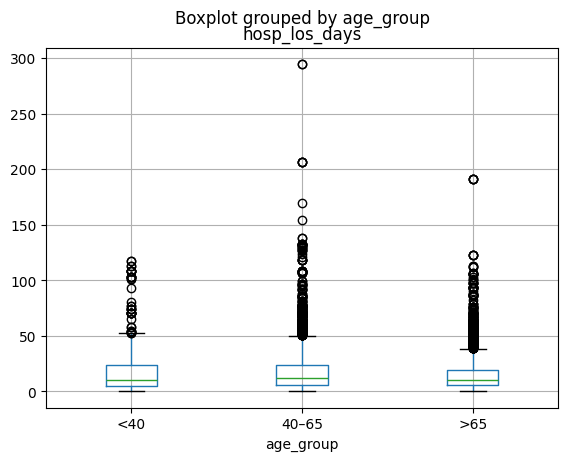

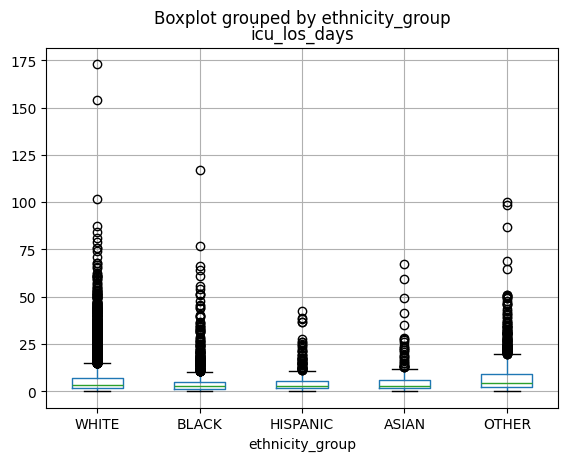

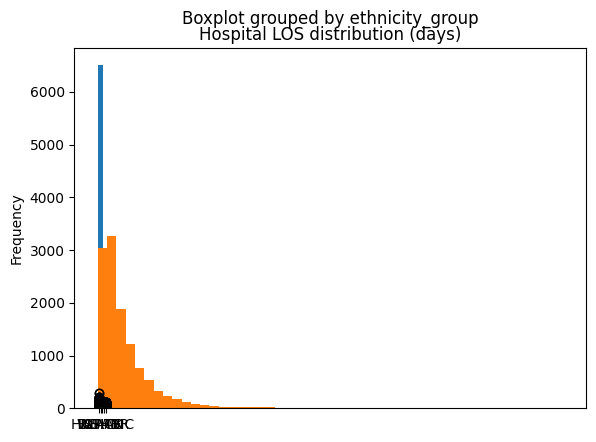

In [ ]:
import numpy as np
import pandas as pd

df = aki_demo.copy()

# --- ensure datetimes + LOS exist ---
for c in ["intime", "outtime", "admittime", "dischtime", "deathtime"]:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

if "icu_los_days" not in df.columns and {"intime", "outtime"}.issubset(df.columns):
    df["icu_los_days"] = (df["outtime"] - df["intime"]).dt.total_seconds() / 86400
if "hosp_los_days" not in df.columns and {"admittime", "dischtime"}.issubset(df.columns):
    df["hosp_los_days"] = (df["dischtime"] - df["admittime"]).dt.total_seconds() / 86400

for c in ["icu_los_days", "hosp_los_days"]:
    if c in df.columns:
        df.loc[df[c] < 0, c] = np.nan

# --- helpers ---
def los_summary_by_group(df, group_col, los_col):
    x = df[[group_col, los_col]].dropna()
    return x.groupby(group_col)[los_col].agg(
        n="count",
        median="median",
        p25=lambda s: s.quantile(0.25),
        p75=lambda s: s.quantile(0.75),
        mean="mean"
    )

# =========================
# 1) LOS nach Mortalität
# =========================
los_by_mort_icu = los_summary_by_group(df, "hospital_mortality", "icu_los_days") if "icu_los_days" in df.columns else None
los_by_mort_hosp = los_summary_by_group(df, "hospital_mortality", "hosp_los_days") if "hosp_los_days" in df.columns else None

print("ICU LOS (days) by hospital_mortality (0=alive, 1=dead):")
print(los_by_mort_icu, "\n")

print("Hospital LOS (days) by hospital_mortality (0=alive, 1=dead):")
print(los_by_mort_hosp, "\n")

# Optional: einfache Visualisierung
ax = df.boxplot(column="icu_los_days", by="hospital_mortality") if "icu_los_days" in df.columns else None
ax = df.boxplot(column="hosp_los_days", by="hospital_mortality") if "hosp_los_days" in df.columns else None


# =========================
# 2) LOS nach Geschlecht
# =========================
if "gender" in df.columns:
    print("ICU LOS (days) by gender:")
    print(los_summary_by_group(df, "gender", "icu_los_days") if "icu_los_days" in df.columns else "NA (missing icu_los_days)", "\n")

    print("Hospital LOS (days) by gender:")
    print(los_summary_by_group(df, "gender", "hosp_los_days") if "hosp_los_days" in df.columns else "NA (missing hosp_los_days)", "\n")

    if "icu_los_days" in df.columns:
        df.boxplot(column="icu_los_days", by="gender")
    if "hosp_los_days" in df.columns:
        df.boxplot(column="hosp_los_days", by="gender")


# =========================
# 3) LOS nach Altersgruppen
# =========================
if "age" in df.columns:
    df.loc[df["age"] > 89, "age"] = 90  # MIMIC-III cap

    bins = [0, 40, 65, 90]
    labels = ["<40", "40–65", ">65"]
    df["age_group"] = pd.cut(df["age"], bins=bins, labels=labels, right=False)

    print("ICU LOS (days) by age_group:")
    print(los_summary_by_group(df, "age_group", "icu_los_days") if "icu_los_days" in df.columns else "NA (missing icu_los_days)", "\n")

    print("Hospital LOS (days) by age_group:")
    print(los_summary_by_group(df, "age_group", "hosp_los_days") if "hosp_los_days" in df.columns else "NA (missing hosp_los_days)", "\n")

    if "icu_los_days" in df.columns:
        df.boxplot(column="icu_los_days", by="age_group")
    if "hosp_los_days" in df.columns:
        df.boxplot(column="hosp_los_days", by="age_group")




ICU LOS (days) by ethnicity_group:
                    n    median       p25       p75      mean
ethnicity_group                                              
WHITE            8439  3.069306  1.692633  6.926719  6.190696
BLACK            1510  2.517951  1.377350  4.972931  5.020227
HISPANIC          382  2.823623  1.677144  5.466950  5.282428
ASIAN             289  2.906944  1.763345  6.032708  5.585679
OTHER            1306  4.191678  2.020715  9.149256  7.670232 

Hospital LOS (days) by ethnicity_group:
                    n     median       p25        p75       mean
ethnicity_group                                                 
WHITE            8431  11.242361  6.006597  21.355208  16.839518
BLACK            1508   8.806250  4.982292  17.716667  13.706233
HISPANIC          382  10.637153  5.130208  20.872396  15.807388
ASIAN             289  10.265972  5.679167  19.694444  16.080049
OTHER            1302  12.810417  6.572396  23.724826  18.209721 



C:\Users\Simon\AppData\Local\Temp\ipykernel_32692\3762541335.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return x.groupby(group_col)[los_col].agg(
C:\Users\Simon\AppData\Local\Temp\ipykernel_32692\3762541335.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return x.groupby(group_col)[los_col].agg(


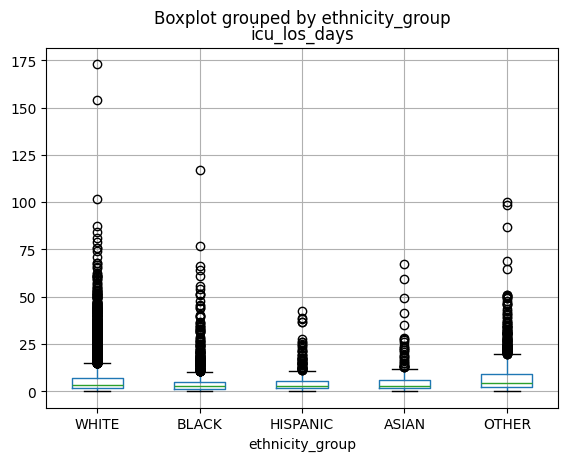

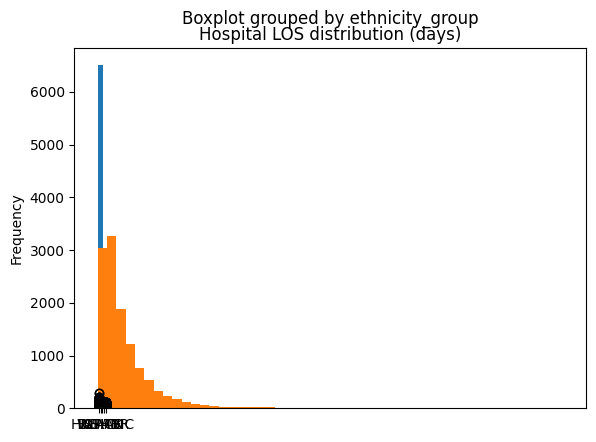

In [8]:
# =========================
# 4) LOS nach Ethnie (grobe Gruppen)
# =========================
if "ethnicity_group" in df.columns:
    order = ["WHITE", "BLACK", "HISPANIC", "ASIAN", "OTHER"]
    df["ethnicity_group"] = pd.Categorical(df["ethnicity_group"], categories=order, ordered=True)

    print("ICU LOS (days) by ethnicity_group:")
    print(los_summary_by_group(df, "ethnicity_group", "icu_los_days") if "icu_los_days" in df.columns else "NA (missing icu_los_days)", "\n")

    print("Hospital LOS (days) by ethnicity_group:")
    print(los_summary_by_group(df, "ethnicity_group", "hosp_los_days") if "hosp_los_days" in df.columns else "NA (missing hosp_los_days)", "\n")

    if "icu_los_days" in df.columns:
        df.boxplot(column="icu_los_days", by="ethnicity_group")
    if "hosp_los_days" in df.columns:
        df.boxplot(column="hosp_los_days", by="ethnicity_group")


# =========================
# 5) LOS-Verteilung (Histogramme)
# =========================
if "icu_los_days" in df.columns:
    df["icu_los_days"].plot.hist(bins=50, title="ICU LOS distribution (days)")
if "hosp_los_days" in df.columns:
    df["hosp_los_days"].plot.hist(bins=50, title="Hospital LOS distribution (days)")
